In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from graphviz import Digraph, Source
from scipy.integrate import odeint

%matplotlib inline

# Моделі масового обслуговування з чергою

In [2]:
lamda = 3.79
mu = 3.7
r = 2
m = 4

### Граф станів

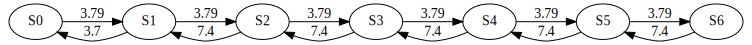

In [3]:
dot = Digraph()

for i in range(r+m+1):
    dot.node('S'+str(i))
    
mu_list = []
    
for i in range(r+m):
    if i < r:
        mu_list.append(mu*(i+1))
        dot.edge('S'+str(i+1), 'S'+str(i), label=str(mu_list[i]))
        dot.edge('S'+str(i), 'S'+str(i+1), label=str(lamda))
    else:
        mu_list.append(mu*r)
        dot.edge('S'+str(i+1), 'S'+str(i), label=str(mu*r))
        dot.edge('S'+str(i), 'S'+str(i+1), label=str(lamda))

mu_arr = np.array(mu_list)

dot.graph_attr['rankdir'] = 'LR'
Source.from_file('Graph.gv')

### Cистема алгебраїчних рівнянь, складена відносно стаціонарних ймовірностей

In [4]:
A = np.zeros((m+r+1, m+r+1))
b = np.zeros(m+r+1)
b[m+r] = 1
k = 0
for i in range(m+r+1):
    if i == 0:
        A[i][k] = -lamda
        A[i][k+1] = mu_arr[i]
        k += 1
    elif i < m+r:
        A[i][k-1] = lamda
        A[i][k] = -(lamda + mu_arr[i-1])
        A[i][k+1] = mu_arr[i]
        k += 1
    else:
        A[i] = np.ones(m+r+1)

string = 'A = {}\n\nb = {}'.format(A, np.array([b]).T)
print(string)

A = [[ -3.79   3.7    0.     0.     0.     0.     0.  ]
 [  3.79  -7.49   7.4    0.     0.     0.     0.  ]
 [  0.     3.79 -11.19   7.4    0.     0.     0.  ]
 [  0.     0.     3.79 -11.19   7.4    0.     0.  ]
 [  0.     0.     0.     3.79 -11.19   7.4    0.  ]
 [  0.     0.     0.     0.     3.79 -11.19   7.4 ]
 [  1.     1.     1.     1.     1.     1.     1.  ]]

b = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


### Розв'язання системи

In [5]:
p = np.linalg.solve(A, b)

frame = pd.DataFrame({'Розв\'язок': [np.array2string(p[0], precision=8)]}, index=['p_0'])
for i in range(1, r+m+1):
    frame = frame.append(pd.DataFrame({'Розв\'язок': [np.array2string(p[i], precision=8)]}, index=['p_'+str(i)]))
    
frame

,Розв'язок
p_0,0.32660251
p_1,0.3345469
p_2,0.17134226
p_3,0.08775502
p_4,0.0449448
p_5,0.02301903
p_6,0.01178947


### Розрахунок стаціонарних характеристик роботи системи

In [6]:
M_X = 0
for i in range(r+m+1):
    if i < r:
        M_X += i*p[i]
    else:
        M_X += r*p[i]
        
K_z = M_X/r

M_Y = 0
for i in range(1, r+1):
    M_Y += i*p[r-i]
    
K_p = M_Y/r

In [7]:
pd.DataFrame({'Показник': [M_X, K_z, M_Y, K_p]},
             index=['Середнє число каналів, зайнятих обслуговуванням заявок',
                    'Коефіцієнт завантаженості',
                    'Середнє число каналів, вільних від обслуговування заявок',
                    'Коефіцієнт простою'])

,Показник
"Середнє число каналів, зайнятих обслуговуванням заявок",1.012248
Коефіцієнт завантаженості,0.506124
"Середнє число каналів, вільних від обслуговування заявок",0.987752
Коефіцієнт простою,0.493876


### Система диференціальних рівнянь Колмогорова, невідомими якої є ймовірності станів, що залежать від часу

In [8]:
def system(P, t, lamda, mu_arr):
    dpdt = []
    for i in range(r+m+1):
        if i == 0:
            dpdt.append(-lamda*P[i] + mu_arr[i]*P[i+1])
        elif i < r+m:
            dpdt.append(lamda*P[i-1] - (lamda + mu_arr[i-1])*P[i] + mu_arr[i]*P[i+1])
        else:
            dpdt.append(lamda*P[i-1] - mu_arr[i-1]*P[i])
            
    return dpdt

### Розв'язок системи

In [9]:
p0 = [1,0,0,0,0,0,0]
t = np.linspace(0, 10, 1001)  # Моменти часу: 0, 1, 2, 3, ..., 9, 10 одиниць часу
p_t = odeint(system, p0, t, args=(lamda, mu_arr,))

p = []
for i in range(r+m+1):
    p.append(p_t[:,i])

d = {}

for i in range(r+m+1):
    d['p_'+str(i)+' (t)'] = {}
    for j in range(11):
        d['p_'+str(i)+' (t)']['t='+str(int(t[j*100]))] = p[i][j*100]
        
pd.DataFrame.from_dict(d, orient='index')

,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,t=9,t=10
p_0 (t),1.0,0.354370,0.330959,0.327366,0.326737,0.326626,0.326607,0.326603,0.326603,0.326603,0.326603
p_1 (t),0.0,0.347459,0.336941,0.334971,0.334622,0.334560,0.334549,0.334547,0.334547,0.334547,0.334547
p_2 (t),0.0,0.167455,0.170976,0.171281,0.171332,0.171340,0.171342,0.171342,0.171342,0.171342,0.171342
p_3 (t),0.0,0.076906,0.086069,0.087460,0.087703,0.087746,0.087753,0.087755,0.087755,0.087755,0.087755
p_4 (t),0.0,0.033573,0.042984,0.044599,0.044884,0.044934,0.044943,0.044944,0.044945,0.044945,0.044945
p_5 (t),0.0,0.014136,0.021378,0.022728,0.022968,0.023010,0.023017,0.023019,0.023019,0.023019,0.023019
p_6 (t),0.0,0.006101,0.010695,0.011595,0.011755,0.011783,0.011788,0.011789,0.011789,0.011789,0.011789


### Розрахунок нестаціонарних характеристик роботи системи

In [10]:
M_X = np.zeros(t.shape[0])
for i in range(t.shape[0]):
    for j in range(r+m+1):
        if j < r:
            M_X[i] += j*p[j][i]
        else:
            M_X[i] += r*p[j][i]
        
K_z = M_X/r

M_Y = np.zeros(t.shape[0])
for i in range(t.shape[0]):
    for j in range(1, r+1):
        M_Y[i] += j*p[r-j][i]
    
K_p = M_Y/r

In [11]:
d = {
     'Середнє число каналів, зайнятих обслуговуванням заявок': {},
     'Коефіцієнт завантаженості': {},
     'Середнє число каналів, вільних від обслуговування заявок': {},
     'Коефіцієнт простою': {}
    }

for j in range(11):
    d['Середнє число каналів, зайнятих обслуговуванням заявок']['t='+str(int(t[j*100]))] = M_X[j*100]
    d['Коефіцієнт завантаженості']['t='+str(int(t[j*100]))] = K_z[j*100]
    d['Середнє число каналів, вільних від обслуговування заявок']['t='+str(int(t[j*100]))] = M_Y[j*100]
    d['Коефіцієнт простою']['t='+str(int(t[j*100]))] = K_p[j*100]

pd.DataFrame.from_dict(d, orient='index')

,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,t=9,t=10
Коефіцієнт завантаженості,0.0,0.471900,0.500571,0.505149,0.505952,0.506094,0.506119,0.506123,0.506124,0.506124,0.506124
Коефіцієнт простою,1.0,0.528100,0.499429,0.494851,0.494048,0.493906,0.493881,0.493877,0.493876,0.493876,0.493876
"Середнє число каналів, вільних від обслуговування заявок",2.0,1.056199,0.998859,0.989703,0.988096,0.987813,0.987763,0.987754,0.987752,0.987752,0.987752
"Середнє число каналів, зайнятих обслуговуванням заявок",0.0,0.943801,1.001141,1.010297,1.011904,1.012187,1.012237,1.012246,1.012248,1.012248,1.012248


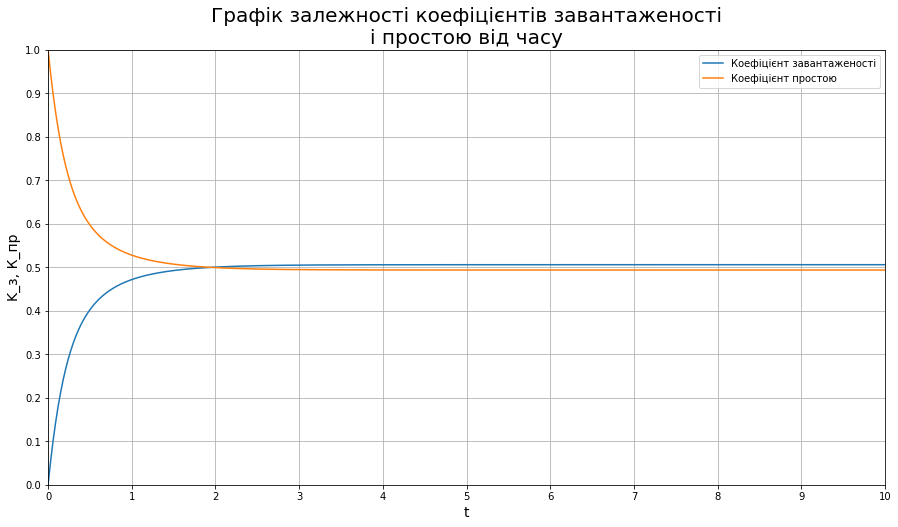

In [12]:
plt.figure(figsize=(15,8))
plt.title('Графік залежності коефіцієнтів завантаженості\nі простою від часу', fontsize=20)
plt.xlabel('t', fontsize=14)
plt.ylabel('K_з, К_пр', fontsize=14)
plt.xticks(np.linspace(0, 10, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid()
plt.plot(t, K_z, label='Коефіцієнт завантаженості')
plt.plot(t, K_p, label='Коефіцієнт простою')
plt.legend()
plt.axis([0, 10, 0, 1])
plt.show()

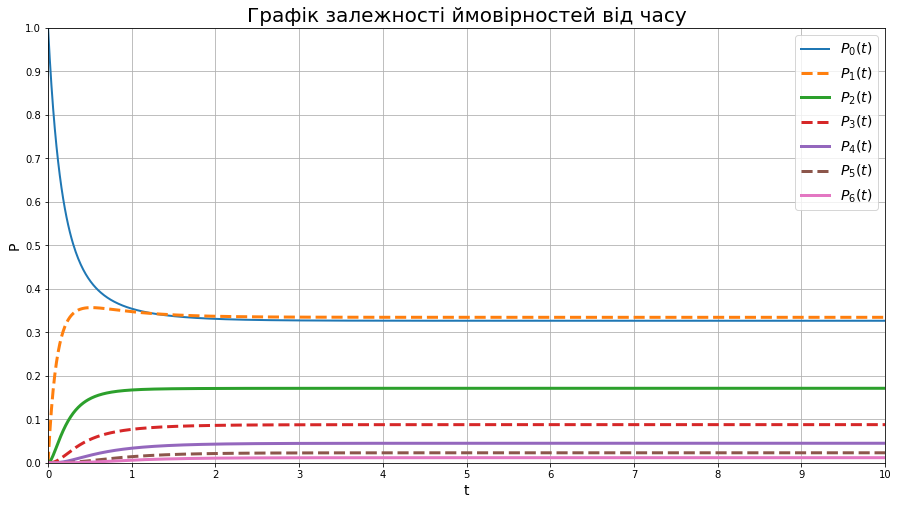

In [13]:
plt.figure(figsize=(15,8))
plt.title('Графік залежності ймовірностей від часу', fontsize=20)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(np.linspace(0, 10, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid()
s = ['-', '--', '-', '--', '-', '--', '-']
linewidth = [2, 3, 3, 3, 3, 3, 3]
for i in range(r+m+1):
    plt.plot(t, p_t[:,i], s[i], label='$P_'+str(i)+'(t)$', linewidth=linewidth[i])
plt.legend(fontsize=14)
plt.axis([0, 10, 0, 1])
plt.show()